In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from utils.words import group_by, russian_stopwords

# Глоссарий:
 - `views` - количество показов
 - `hits` - количество просмотров
 - `likes` - количество лайков статьи
 - `comments` - количество комментариев к статье
 - `favorites` - количество добавлений статьи в избранное
 - `tags` - теги статьи
 - `tags_count` - количество тегов у статьи
 - `title_len` - длина заголовка статьи (в символах)
 - `content_len` - длина контента статьи (в символах)
 - `date` - дата публикации статьи
 - `days_since_post` - количество дней с момента публикации статьи
 - `images_count` - количество изображений в статье
 - `author_name` - имя автора статьи
 - `author_total_views` - общее количество просмотров автора
 - `author_total_posts` - общее количество статей автора
 - `cluster` - номер кластера, к которому относится статья


In [22]:
data = pd.read_csv('./vc_posts.csv')
data = data[(data['title'].notnull()) & (data['is_advertisement'] == False) & (data['author_type'] == 'self')]
data['tags'] = data['tags'].apply(eval)
data['tags_count'] = data['tags'].apply(len)
data['title_len'] = data['title'].apply(len)
data['content_len'] = data['content'].apply(len)
data['date'] = data['date'].apply(datetime.datetime.strptime, args=('%a, %d %b %Y %H:%M:%S %z',))
data['days_since_post'] = data['date'].apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).days)
data['images_count'] = data['content'].apply(lambda x: x.count('<img'))
data['ctr'] = data['hits'] / data['views']
data = data[data['days_since_post'] < 500]
grouped_by_author = group_by(data, 'author_name')
data['author_total_views'] = data['author_name'].apply(
    lambda x: grouped_by_author[grouped_by_author['author_name'] == x]['views'].values[0])
data['author_total_posts'] = data['author_name'].apply(
    lambda x: grouped_by_author[grouped_by_author['author_name'] == x]['count'].values[0])
data.head()

,_id,author_name,author_type,comments,content,createdAt,date,favorites,hits,id,...,url,views,tags_count,title_len,content_len,days_since_post,images_count,ctr,author_total_views,author_total_posts
0,6616c4acd2ad343afb59d936,Успешный провал,self,2,"<div class=""l-island-a"">\n \n <p>Отк...",2024-04-10T16:56:12.412Z,2024-04-09 18:42:14+03:00,0,372,1118037,...,https://vc.ru/life/1118037-kak-poteryat-biznes...,2644,0,33,17238,12,1,0.140696,5478,3
1,6616c4acd2ad343afb59d935,Realm Digital,self,2,"<figure class=""figure-image"">\n <style>\n ...",2024-04-10T16:56:12.060Z,2024-04-08 17:01:57+03:00,1,64,1115687,...,https://vc.ru/life/1115687-zachem-vashemu-bizn...,790,0,47,7480,13,1,0.081013,790,1
3,6616c4abd2ad343afb59d933,Pyrobyte,self,17,"<div class=""l-island-a"">\n \n <p>При...",2024-04-10T16:56:11.606Z,2024-04-09 07:47:32+03:00,31,903,1110527,...,https://vc.ru/transport/1110527-8-luchshih-ser...,10583,0,70,50264,12,2,0.085326,74494,7
4,6616c4abd2ad343afb59d932,Timur Taepov,self,0,"<div class=""l-island-a"">\n \n <p>Это...",2024-04-10T16:56:11.119Z,2024-04-09 19:28:03+03:00,2,47,1118101,...,https://vc.ru/chatgpt/1118101-kak-sozdat-ai-pr...,501,0,61,7340,12,0,0.093812,1398,2
6,6616c4aad2ad343afb59d930,Мать Telegram,self,30,"<div class=""l-island-a"">\n \n <p>Я и...",2024-04-10T16:56:10.504Z,2024-04-09 15:03:47+03:00,9,632,1092222,...,https://vc.ru/money/1092222-kak-vladelcy-blogo...,5345,0,45,11212,12,0,0.118241,5345,1


# Данные сгруппированные по тематике и отсортированные по среднему количеству просмотров

In [23]:
grouped_subsite = group_by(data, 'subsite_label')
grouped_subsite.sort_values(by='avg_hits', ascending=False).head(10)

,subsite_label,count,views,likes,comments,favorites,hits,avg_hits,avg_views,avg_likes,avg_comments,avg_favorites
subsite_label,,,,,,,,,,,,
nikanorova,nikanorova,3,37521,224,205,422,148444,49481.333333,12507.0000,74.666667,68.333333,140.666667
tinkoff,tinkoff,2,23037,50,49,13,40757,20378.500000,11518.5000,25.000000,24.500000,6.500000
molyanov,molyanov,2,53163,280,275,292,29646,14823.000000,26581.5000,140.000000,137.500000,146.000000
edu,edu,35,15092,56,26,219,421433,12040.942857,431.2000,1.600000,0.742857,6.257143
vk,vk,1,31939,33,37,9,9656,9656.000000,31939.0000,33.000000,37.000000,9.000000
finder,finder,3,49653,166,266,107,20003,6667.666667,16551.0000,55.333333,88.666667,35.666667
ozon,ozon,1,18265,41,104,18,6560,6560.000000,18265.0000,41.000000,104.000000,18.000000
finam,finam,1,1554,4,0,1,5563,5563.000000,1554.0000,4.000000,0.000000,1.000000
rodion_sev,rodion_sev,2,225,1,0,1,11073,5536.500000,112.5000,0.500000,0.000000,0.500000


# Данные сгруппированные по тематике и отсортированные по количеству просмотров

In [24]:
grouped_subsite.sort_values(by='hits', ascending=False).head(10)

,subsite_label,count,views,likes,comments,favorites,hits,avg_hits,avg_views,avg_likes,avg_comments,avg_favorites
subsite_label,,,,,,,,,,,,
unknown,unknown,6931,3413942,14142,16658,7660,3867709,558.030443,492.561247,2.040398,2.403405,1.105180
marketing,marketing,779,3272547,7183,6011,6804,687945,883.112965,4200.958922,9.220796,7.716303,8.734275
money,money,399,1071084,3060,3897,1532,591528,1482.526316,2684.421053,7.669173,9.766917,3.839599
life,life,311,2000086,5706,6576,4259,528041,1697.881029,6431.144695,18.347267,21.144695,13.694534
claim,claim,424,934832,3091,9797,589,495198,1167.919811,2204.792453,7.290094,23.106132,1.389151
edu,edu,35,15092,56,26,219,421433,12040.942857,431.200000,1.600000,0.742857,6.257143
flood,flood,160,465960,1486,2040,1008,406779,2542.368750,2912.250000,9.287500,12.750000,6.300000
crypto,crypto,233,338991,698,473,453,362933,1557.652361,1454.896996,2.995708,2.030043,1.944206
services,services,143,626060,1975,2055,2777,316814,2215.482517,4378.041958,13.811189,14.370629,19.419580


# Семантический анализ заголовков статей
## Делим на 2 кластера

In [29]:
vec = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 3))
vec.fit(data['title'])
features = vec.transform(data['title'])

cluster = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster.fit(features)

yhat = cluster.predict(features)
data['cluster'] = yhat

data = data[data['cluster'] == 0]
data[['title', 'cluster']].head()

,title,cluster
0,Как потерять бизнес за три месяца,0
1,Зачем Вашему Бизнесу Профессиональный Веб-Сайт?,0
3,8 лучших сервисов для автоматизации транспортн...,0
4,Как создать AI-продукт новичку? Базовые поняти...,0
6,Как владельцы блогов в Telegram теряют деньги,0


# Пробуем разделить на 10 кластеров

In [30]:
vec = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 3))
vec.fit(data['title'])
features = vec.transform(data['title'])

cluster = KMeans(n_clusters=10, random_state=20, n_init=10)
cluster.fit(features)

yhat = cluster.predict(features)
data['cluster'] = yhat

In [31]:
grouped_cluster = group_by(data, 'cluster')
grouped_cluster = grouped_cluster.sort_values(by='avg_hits', ascending=False)
grouped_cluster[['count', 'avg_views', 'avg_hits']].head(10)

,count,avg_views,avg_hits
cluster,,,
7,155,1590.832258,3235.374194
3,185,3419.464865,2417.443243
9,152,2525.000000,1501.763158
5,394,2157.114213,962.185279
2,83,1173.722892,900.228916
0,9017,1530.230010,747.508151
6,61,449.639344,746.081967
8,453,1877.538631,720.922737
1,113,1575.212389,540.424779


In [32]:
cluster = KMeans(n_clusters=10, random_state=42, n_init=10)
features = data['hits'].values.reshape(-1, 1)
cluster.fit(features)

yhat = cluster.predict(features)

data['popularity_cluster'] = yhat

Text(0.5, 1.0, 'Кол-во тэгов vs Показы')

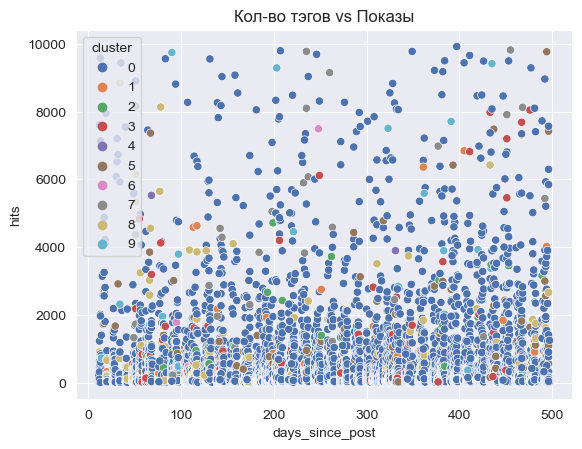

In [33]:
ax = sns.scatterplot(x="days_since_post", y="hits", data=data[data['hits'] < 10_000], hue='cluster', palette='deep')
ax.set_title('Кол-во тэгов vs Показы')

In [34]:
grouped_cluster = group_by(data, 'popularity_cluster').sort_values(by='avg_hits', ascending=False)

samples = []
for cat in grouped_cluster[grouped_cluster['count'] > 20]['popularity_cluster'].values[:4]:
    samples.append(data[data['popularity_cluster'] == cat].values[:4])

sub_set = pd.DataFrame(np.stack(samples, axis=0).reshape(-1, data.shape[1]), columns=data.columns)
sub_set[['title', 'views', 'hits', 'popularity_cluster']].head(40)

,title,views,hits,popularity_cluster
0,Сколько зарабатывает бизнес на шаурме?,65828,27211,1
1,❗️Сбербанк объявил о покупке ВТБ,39161,28734,1
2,"Рыбинск. Что мы придумали, кроме вывесок",56942,24264,1
3,Тинькофф раскрыл новый сценарий мошенничества:...,13323,32485,1
4,Как я склеил картон и продал на маркетплейсах ...,44063,18264,7
5,Сегодня без субботнего самопиара. Скорбим вмес...,68915,13921,7
6,"Альфа банк не знает, почему заморозил 250 тыс....",20933,14380,7
7,Работа в ПВЗ Озон: отзыв по моему реальному опыту,5371,15416,7
8,Кладоискатель нашего времени. Как британец ище...,22098,7602,3
9,Саббатикал. Или как выйти на пенсию в 35 лет у...,22980,9571,3


# Корреляционная матрица

In [35]:
cormat = data[
    ['views', 'tags_count', 'favorites', 'likes', 'comments', 'hits', 'title_len', 'content_len', 'images_count',
     'days_since_post', 'author_total_posts', 'author_total_views', 'ctr']].corr()
cormat

,views,tags_count,favorites,likes,comments,hits,title_len,content_len,images_count,days_since_post,author_total_posts,author_total_views,ctr
views,1.000000,-0.015179,0.433682,0.554875,0.542901,0.248832,0.118747,0.191071,0.030251,-0.012974,-0.041122,0.474079,-0.018042
tags_count,-0.015179,1.000000,-0.005818,-0.012959,-0.003435,-0.000953,0.002415,0.021367,0.031993,-0.023893,-0.006514,-0.002515,0.009995
favorites,0.433682,-0.005818,1.000000,0.598601,0.460027,0.470210,0.098050,0.236281,0.042457,0.082945,-0.042047,0.204594,0.020137
likes,0.554875,-0.012959,0.598601,1.000000,0.731817,0.412818,0.090658,0.194768,0.026487,0.039085,-0.044455,0.302745,0.014382
comments,0.542901,-0.003435,0.460027,0.731817,1.000000,0.368129,0.073860,0.129196,0.019017,0.028269,-0.041498,0.307086,0.018142
hits,0.248832,-0.000953,0.470210,0.412818,0.368129,1.000000,0.057622,0.235596,0.012261,0.093348,-0.018245,0.121167,0.214423
title_len,0.118747,0.002415,0.098050,0.090658,0.073860,0.057622,1.000000,0.143321,-0.003145,0.002209,0.074400,0.078514,0.000058
content_len,0.191071,0.021367,0.236281,0.194768,0.129196,0.235596,0.143321,1.000000,0.121806,0.018615,-0.035523,0.107947,0.031855
images_count,0.030251,0.031993,0.042457,0.026487,0.019017,0.012261,-0.003145,0.121806,1.000000,-0.050820,-0.007318,0.022299,-0.010562
days_since_post,-0.012974,-0.023893,0.082945,0.039085,0.028269,0.093348,0.002209,0.018615,-0.050820,1.000000,-0.004678,0.024298,0.087607


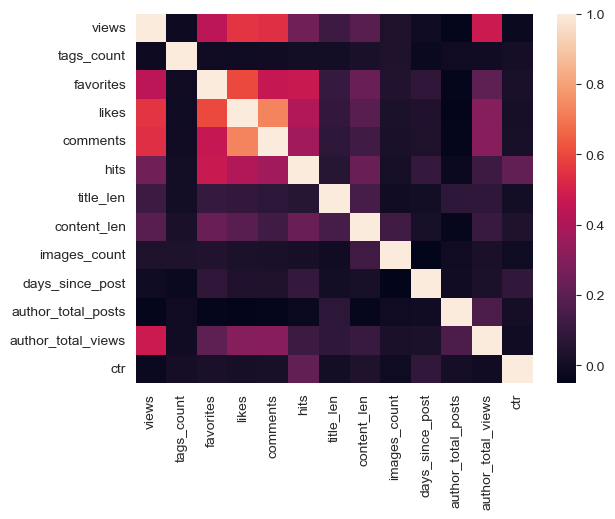

In [36]:
sns.heatmap(cormat);

## Заключения
- VC продвигает посты с большим количеством лайков и комментариев (лайки и комментарии коррелируют с просмотрами больше, чем сами просмотры)
- Есть корреляция между длиной контента и лайками + добавлениями в избранное
- Есть слабая корреляция между длиной заголовка и лайками + комментариями
- Есть корреляция между количеством тэгов и просмотрами

# Scatter plots

Text(0, 0.5, 'Просмотры')

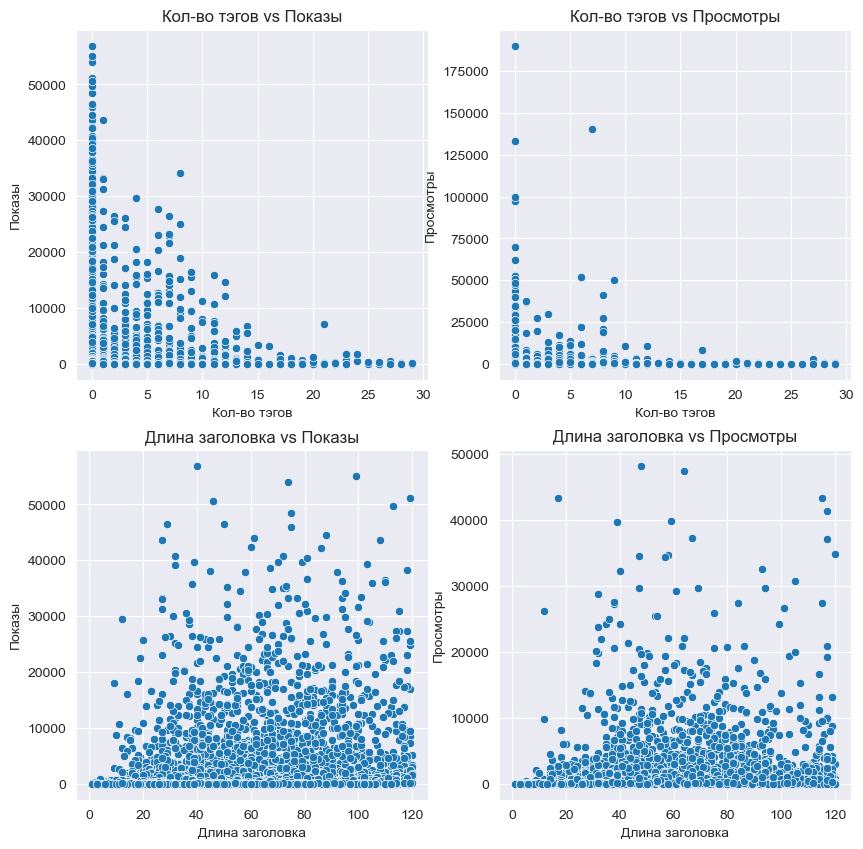

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

_data = data[(data['views'] < 60_000) & (data['tags_count'] < 30)]
ax = sns.scatterplot(x="tags_count", y="views", data=_data, ax=axs[0, 0])
ax.set_title('Кол-во тэгов vs Показы')
ax.set_xlabel('Кол-во тэгов')
ax.set_ylabel('Показы')

_data = data[(data['hits'] < 1_000_000) & (data['tags_count'] < 30)]
ax = sns.scatterplot(x="tags_count", y="hits", data=_data, ax=axs[0, 1])
ax.set_title('Кол-во тэгов vs Просмотры')
ax.set_xlabel('Кол-во тэгов')
ax.set_ylabel('Просмотры')

_data = data[(data['views'] < 60_000)]
ax = sns.scatterplot(x="title_len", y="views", data=_data, ax=axs[1, 0])
ax.set_title('Длина заголовка vs Показы')
ax.set_xlabel('Длина заголовка')
ax.set_ylabel('Показы')

_data = data[(data['hits'] < 50_000)]
ax = sns.scatterplot(x="title_len", y="hits", data=_data, ax=axs[1, 1])
ax.set_title('Длина заголовка vs Просмотры')
ax.set_xlabel('Длина заголовка')
ax.set_ylabel('Просмотры')

Text(0, 0.5, 'Комментарии')

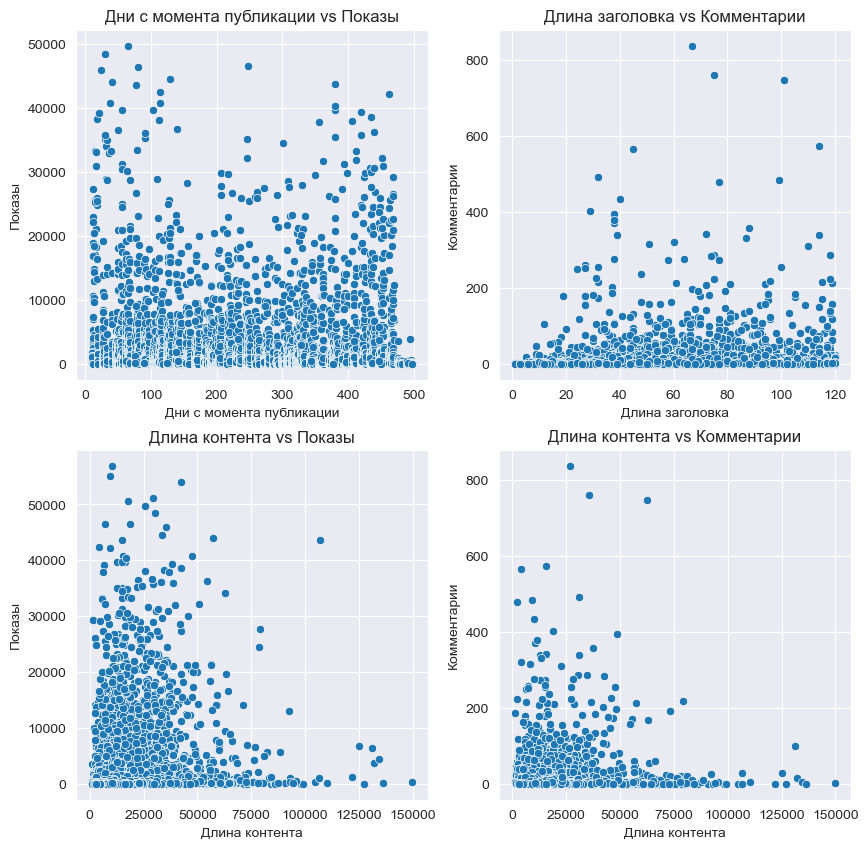

In [43]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
_data = data[(data['views'] < 50_000) & (data['days_since_post'] < 500)]
ax = sns.scatterplot(x="days_since_post", y="views", data=_data, ax=axs[0, 0])
ax.set_title('Дни с момента публикации vs Показы')
ax.set_xlabel('Дни с момента публикации')
ax.set_ylabel('Показы')

ax = sns.scatterplot(x="title_len", y="comments", data=data, ax=axs[0, 1])
ax.set_title('Длина заголовка vs Комментарии')
ax.set_xlabel('Длина заголовка')
ax.set_ylabel('Комментарии')

_data = data[(data['content_len'] < 150_000) & (data['views'] < 60_000)]
ax = sns.scatterplot(x="content_len", y="views", data=_data, ax=axs[1, 0])
ax.set_title('Длина контента vs Показы')
ax.set_xlabel('Длина контента')
ax.set_ylabel('Показы')

_data = data[(data['content_len'] < 150_000) & (data['comments'] < 1000)]
ax = sns.scatterplot(x="content_len", y="comments", data=_data, ax=axs[1, 1])
ax.set_title('Длина контента vs Комментарии')
ax.set_xlabel('Длина контента')
ax.set_ylabel('Комментарии')

Text(0, 0.5, 'Просмотры')

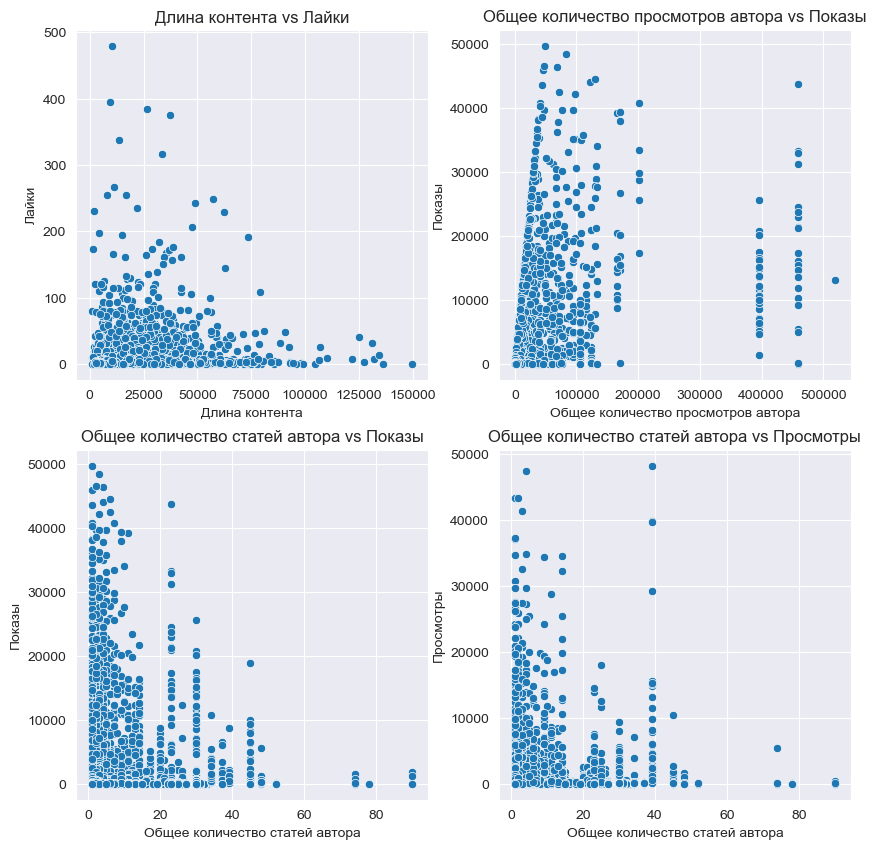

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

_data = data[(data['content_len'] < 150_000) & (data['likes'] < 500)]
ax = sns.scatterplot(x="content_len", y="likes", data=_data, ax=axs[0, 0])
ax.set_title('Длина контента vs Лайки')
ax.set_xlabel('Длина контента')
ax.set_ylabel('Лайки')

_data = data[(data['views'] < 50_000) & (data['author_total_views'] < 5_000_000)]
ax = sns.scatterplot(x="author_total_views", y="views", data=_data, ax=axs[0, 1])
ax.set_title('Общее количество просмотров автора vs Показы')
ax.set_xlabel('Общее количество просмотров автора')
ax.set_ylabel('Показы')

_data = data[(data['views'] < 50_000) & (data['author_total_posts'] < 1000)]
ax = sns.scatterplot(x="author_total_posts", y="views", data=_data, ax=axs[1, 0])
ax.set_title('Общее количество статей автора vs Показы')
ax.set_xlabel('Общее количество статей автора')
ax.set_ylabel('Показы')

_data = data[(data['hits'] < 50_000) & (data['author_total_posts'] < 1000)]
ax = sns.scatterplot(x="author_total_posts", y="hits", data=_data, ax=axs[1, 1])
ax.set_title('Общее количество статей автора vs Просмотры')
ax.set_xlabel('Общее количество статей автора')
ax.set_ylabel('Просмотры')